Ablation for Symphony temperatures on QM9!

In [24]:
from typing import *
import matplotlib.pyplot as plt
import seaborn as sns
import jax
import jax.numpy as jnp
import chex
import functools
import pandas as pd
import e3nn_jax as e3nn
import posebusters
import sys
import os
import ase
import ase.io
import rdkit.Chem as Chem
import nglview as nv
sys.path.append("../..")

In [25]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
%autoreload 2
import sys
sys.path.append("..")
from analyses.metrics import *

Paths:

In [29]:
generated_paths = {}
template = "/Users/ameyad/Documents/spherical-harmonic-net/analyses/analysed_workdirs/qm9_bessel_embedding_attempt6_edm_splits_iclr2024_submission/e3schnet_and_nequip/interactions=3/l=5/position_channels=2/channels=64/fait={fait}/pit={pit}/step=9930000_res_alpha=359_res_beta=180/molecules"
for pit in ["0.01", "0.1", "1.0", "10.0", "100.0"]:
    for fait in ["0.01", "0.1", "1.0", "10.0", "100.0"]:
        path = template.format(pit=pit, fait=fait)
        if not os.path.exists(path):
            continue
        generated_paths[(pit, fait)] = path

Corresponding molecules:

In [30]:
all_generated_molecules = {
    model: get_all_molecules(path) for model, path in generated_paths.items()
}

valid_molecules = {
    model: get_all_valid_molecules(molecules) for model, molecules in all_generated_molecules.items()
}

In [34]:
# Make a dataframe for each model for the validity of the molecules.
all_results_df = pd.DataFrame(columns=["pit", "fait", "validity"])

for model, molecules in valid_molecules.items():
    if len(molecules) == 0:
        continue
    validity_fraction = compute_validity(all_generated_molecules[model], molecules)
    uniqueness_fraction = compute_uniqueness(molecules)
    pit, fait = model

    all_results_df = pd.concat(
        [
            all_results_df,
            pd.DataFrame.from_records(
                [
                    {
                        "pit": pit,
                        "fait": fait,
                        "validity": validity_fraction,
                        "uniqueness": uniqueness_fraction,
                    }
                ]
            ),
        ],
        ignore_index=True,
    )
all_results_df

,pit,fait,validity,uniqueness
0,0.01,1.0,0.0032,0.937500
1,0.1,1.0,0.0021,0.952381
2,1.0,0.01,0.0432,0.328704
3,1.0,0.1,0.1836,0.611111
4,1.0,1.0,0.8301,0.977714
5,1.0,10.0,0.8989,0.547892
6,1.0,100.0,0.8977,0.522892
7,10.0,1.0,0.9560,0.788180
8,100.0,1.0,0.9609,0.757935


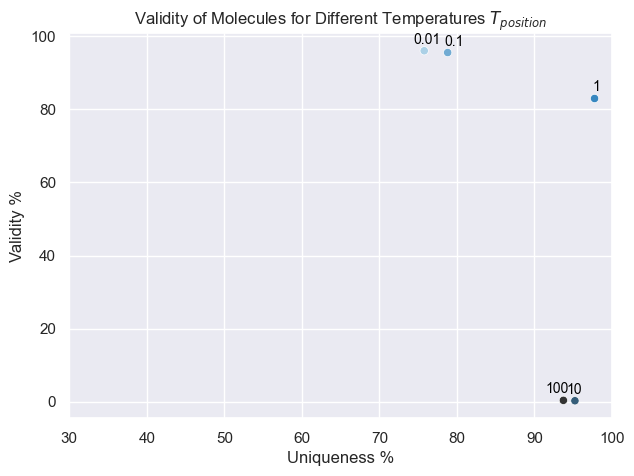

In [82]:
# Plot the validity of the molecules for each model.
results_df = all_results_df.copy()[all_results_df["fait"] == "1.0"]
results_df["pit"] = results_df["pit"].astype(float)
results_df["temperature"] = 1. / results_df["pit"]
results_df["log_temperature"] = results_df["temperature"].apply(np.log10)
results_df["validity"] = results_df["validity"] * 100
results_df["uniqueness"] = results_df["uniqueness"] * 100

plt.figure(figsize=(7, 5))
sns.set_theme(style="darkgrid")
sns.scatterplot(
    data=results_df, x="uniqueness", y="validity",
    hue="log_temperature",
    palette="Blues_d",
)
plt.title(r"Validity of Molecules for Different Temperatures $T_{position}$")
plt.xlim(30, 100)
plt.xlabel("Uniqueness %")
plt.ylabel("Validity %")
# Show temperature instead of log_temperature in legend.
handles, labels = plt.gca().get_legend_handles_labels()
labels = [f"$T={10**float(label):.2f}$" for label in labels]
plt.legend(handles, labels)
# Hide legend.
plt.gca().get_legend().remove()


for i, row in results_df.iterrows():
    plt.text(
        row['uniqueness'] + 1.01 * jax.random.uniform(jax.random.PRNGKey(i + 1),  minval=-1, maxval=1),
        row['validity'] + 2,
        f"{str(row['temperature']).rstrip('0').rstrip('.')}",
        horizontalalignment='center',
        size='small',
        color='black',
    )
plt.savefig("pdfs/validity_vs_position_temperatures.pdf", dpi=500, bbox_inches='tight')
plt.show()

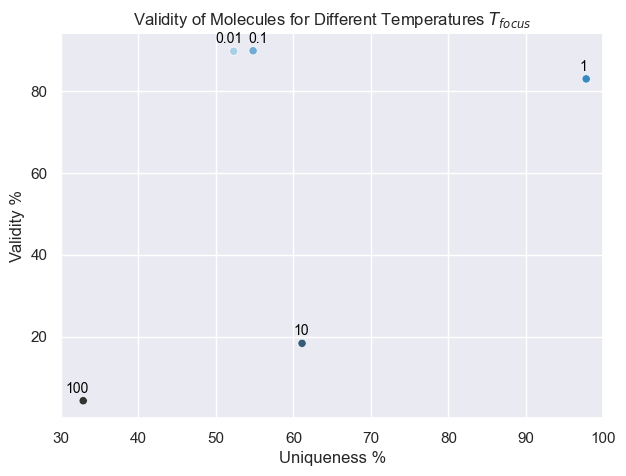

,pit,fait,validity,uniqueness,temperature,log_temperature
2,1.0,0.01,4.32,32.870370,100.00,2.0
3,1.0,0.10,18.36,61.111111,10.00,1.0
4,1.0,1.00,83.01,97.771353,1.00,0.0
5,1.0,10.00,89.89,54.789187,0.10,-1.0
6,1.0,100.00,89.77,52.289183,0.01,-2.0


In [85]:
# Plot the validity of the molecules for each model.
results_df = all_results_df.copy()[all_results_df["pit"] == "1.0"]
results_df["fait"] = results_df["fait"].astype(float)
results_df["temperature"] = 1. / results_df["fait"]
results_df["log_temperature"] = results_df["temperature"].apply(np.log10)
results_df["validity"] = results_df["validity"] * 100
results_df["uniqueness"] = results_df["uniqueness"] * 100

plt.figure(figsize=(7, 5))
sns.set_theme(style="darkgrid")
sns.scatterplot(
    data=results_df, x="uniqueness", y="validity",
    hue="log_temperature",
    palette="Blues_d",
)
plt.title(r"Validity of Molecules for Different Temperatures $T_{focus}$")
plt.xlim(30, 100)
plt.xlabel("Uniqueness %")
plt.ylabel("Validity %")
# Show temperature instead of log_temperature in legend.
handles, labels = plt.gca().get_legend_handles_labels()
labels = [f"$T={10**float(label):.2f}$" for label in labels]
plt.legend(handles, labels)
# Hide legend.
plt.gca().get_legend().remove()


for i, row in results_df.iterrows():
    plt.text(
        row['uniqueness'] + jax.random.uniform(jax.random.PRNGKey(i + 8),  minval=-1, maxval=1),
        row['validity'] + 2,
        f"{str(row['temperature']).rstrip('0').rstrip('.')}",
        horizontalalignment='center',
        size='small',
        color='black',
    )
plt.savefig("pdfs/validity_vs_focus_temperatures.pdf", dpi=500, bbox_inches='tight')
plt.show()

results_df

In [ ]:
results_df

,pit,validity,uniqueness,temperature
0,0.01,0.0032,0.937500,100.00
1,0.10,0.0021,0.952381,10.00
2,1.00,0.8303,0.977719,1.00
3,10.00,0.9560,0.788180,0.10
4,100.00,0.9609,0.757935,0.01


In [ ]:
formatted_validity_df = validity_df.transpose()
formatted_validity_df.columns = formatted_validity_df.iloc[0]
formatted_validity_df *= 100
formatted_validity_df = formatted_validity_df.drop("model")
formatted_validity_df = formatted_validity_df.astype(float)
formatted_validity_df = formatted_validity_df.round(2)
formatted_validity_df = formatted_validity_df.astype(str)
print(formatted_validity_df.style.to_latex())